### Credenciais de Acesso Kaggle

In [2]:
{"username":"jcss03","key":"caf02cc87bdafff295f9eb6897072757"}

{'username': 'jcss03', 'key': 'caf02cc87bdafff295f9eb6897072757'}

### Imports

In [3]:
!pip install opendatasets
!pip install pandas

import opendatasets as od
import pandas
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

import re

from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### Download Dataset

In [4]:
# download data from kaggle
od.download("https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis/download?datasetVersionNumber=2")

Skipping, found downloaded files in "./twitter-entity-sentiment-analysis" (use force=True to force download)


In [5]:
# caminho para o dataset
!ls ./twitter-entity-sentiment-analysis

twitter_training.csv  twitter_validation.csv


### Acesso ao Drive

In [6]:
# Acesso a pasta do drive
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [7]:
# exemplo
!ls /content/drive/MyDrive/'Trabalho de Graduação'

'Apresentação sem título.gslides'  'Proposta de TG'
 Fontes.gdoc			    scripts
'Pesquisas - Links.gdoc'	   'Trabalho de Graduação 2022'


### Loading Datasets
* Train
* Test

In [8]:
dataset_train = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_training.csv',names=['Tweet_ID','entity','sentiment','Tweet content'],header=None)
dataset_validation = pd.read_csv('./twitter-entity-sentiment-analysis/twitter_validation.csv',names=['Tweet_ID','entity','sentiment','Tweet content'],header=None)

In [9]:
print('Exemplo do dataset')
dataset_train.sample(5)

Exemplo do dataset


,Tweet_ID,entity,sentiment,Tweet content
37860,5292,Hearthstone,Irrelevant,My top 5 diverse books:. . 1 The City of Brass...
14218,2837,Dota2,Positive,can't fucking believe knowing i played DotA2 e...
56604,11313,TomClancysRainbowSix,Neutral,One of the most infamous . . youtube.com/watc...
21246,4038,CS-GO,Negative,Finally played Rainbow Six Siege for the first...
31072,7337,LeagueOfLegends,Positive,Playing league of legends while also listening...


#### Encodificar Targets

In [10]:
data = dataset_train[['Tweet content','sentiment']].rename(columns={"Tweet content": "text", "sentiment": "target"})
data.target = pd.Categorical(data.target)

data['code'] = data.target.cat.codes
print('#'*100)
print(f'Targets: {data.target.unique()}')
print(f'Codes: {data.code.unique()}')
print('#'*100)
data.sample(5)

####################################################################################################
Targets: ['Positive', 'Neutral', 'Negative', 'Irrelevant']
Categories (4, object): ['Irrelevant', 'Negative', 'Neutral', 'Positive']
Codes: [3 2 1 0]
####################################################################################################


,text,target,code
33059,buy yo Alix or formula now am big big fan of i...,Irrelevant,0
3113,it’s like the universe doesn’t want me to get ...,Neutral,2
29237,helping information sUper an experience on ape...,Neutral,2
21731,One of the premier valorant players for Brusse...,Irrelevant,0
65724,Johnson & Johnson posts 'temporary' Tylenol sh...,Neutral,2


#### Remover valores Null

In [11]:
print('#'*100)
qtd_null_values = np.sum(data.isnull().any(axis=1))
print(f'Shape dos dados: {data.shape}')
print(f'Number null values = {qtd_null_values}')

# dropna values
data = data.dropna().reset_index(drop=True)

print('#'*100)
qtd_null_values = np.sum(data.isnull().any(axis=1))
print(f'Shape dos dados: {data.shape}')
print(f'Number null values = {qtd_null_values}')

####################################################################################################
Shape dos dados: (74682, 3)
Number null values = 686
####################################################################################################
Shape dos dados: (73996, 3)
Number null values = 0


### Processing Text
* stopwords
* punctuation
* Stemming(reducing the words to their derived stems)
* Lemmatization(reducing the derived words to their root form known as lemma)
* removing unnecessary characters
* lower case text to better generalization

In [12]:
# recebe texto e processa
def processing_text(text,flag_punctuation=False,flag_stopwords=False,flag_stem=False,flag_lemma=False):

  ##############################################################################
  # funções

  # maketrans explained - 'https://www.w3schools.com/python/ref_string_maketrans.asp'
  def cleaning_punctuations(text):
      english_punctuations = string.punctuation
      punctuations_list = english_punctuations

      translator = str.maketrans('', '', punctuations_list)
      return text.translate(translator)
  
  # remover stopwords
  def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    text = " ".join([word for word in text.split(' ') if word not in stop_words])
    return text

  # removendo chars repetidos
  def cleaning_repeating_char(text):
      return re.sub(r'(.)1+', r'1', text)

  # removing stem
  def stemming(text):
    ps = PorterStemmer()
    text = " ".join([ps.stem(word) for word in text.split(' ')])
    return text

  def lemmatizer(text):
      lm = nltk.WordNetLemmatizer()
      text = " ".join([lm.lemmatize(word) for word in text.split(' ')])
      return text
  ##############################################################################

  # Processing

  # lower all string of text
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip())

  # remover pontuações
  if flag_punctuation:
    text = cleaning_punctuations(text)

  # remover stopwords
  if flag_stopwords:
    text = remove_stopwords(text)

  # remover repetições
  text = cleaning_repeating_char(text)

  # lenma
  if flag_lemma:
    text = lemmatizer(text)

  # stem:
  if flag_stem:
    text = stemming(text)

  return text

In [13]:
example = data.text.iloc[100]
example

'Grounded almost was pretty cool even despite the top tier unfunny writing until we became yet another annoying crafting game. I seriously can’t wait on this shitty trend to die'

In [14]:
clean_text = processing_text(example,flag_punctuation=True,flag_stopwords=True,flag_lemma=True)
clean_text

'grounded almost pretty cool even despite top tier unfunny writing became yet another annoying crafting game seriously cant wait shitty trend die'

In [15]:
# clean text
data['clean_text'] = data['text'].apply(lambda x: processing_text(x,flag_punctuation=True,flag_stopwords=True,flag_lemma=True))

In [16]:
tokenizer = nltk.RegexpTokenizer(r"\w+")

data['tokens'] = data['clean_text'].apply(lambda x: tokenizer.tokenize(x))

In [17]:
data.sample(10)

,text,target,code,clean_text,tokens
34455,This is the AES key of the new decrypted packa...,Neutral,2,aes key new decrypted package aes key 0x724bf...,"[aes, key, new, decrypted, package, aes, key, ..."
43810,@PUBGMOBILE_IN. I gave the mail id and passwo...,Irrelevant,0,pubgmobilein gave mail id password someone el...,"[pubgmobilein, gave, mail, id, password, someo..."
8154,.@TPAIN....<unk> Come @PlayOverwatch with some...,Irrelevant,0,tpainunk come playoverwatch u mad luv ya,"[tpainunk, come, playoverwatch, u, mad, luv, ya]"
49413,Memories of decades in a common thread,Positive,3,memory decade common thread,"[memory, decade, common, thread]"
10686,The only fridge I may need in November.,Irrelevant,0,fridge may need november,"[fridge, may, need, november]"
19471,Where So the powerful angel... people in World...,Neutral,2,powerful angel people world warcraft stormcast...,"[powerful, angel, people, world, warcraft, sto..."
67906,Niggas is impressed by that lame ass phone game,Neutral,2,nigga impressed lame as phone game,"[nigga, impressed, lame, as, phone, game]"
11343,Disgusting smh,Negative,1,disgusting smh,"[disgusting, smh]"
47206,What I only want to give Tommy & Nelson @HomeD...,Positive,3,want give tommy nelson homedepotstore,"[want, give, tommy, nelson, homedepotstore]"
63927,I love this list,Positive,3,love list,"[love, list]"


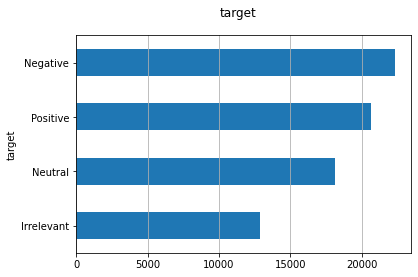

In [18]:
fig, ax = plt.subplots()
fig.suptitle("target", fontsize=12)
data["target"].reset_index().groupby("target").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

In [19]:
data = data[data.target != 'Irrelevant']


In [20]:
print(data.target.unique())
print(data.code.unique())


['Positive', 'Neutral', 'Negative']
Categories (4, object): ['Irrelevant', 'Negative', 'Neutral', 'Positive']
[3 2 1]


### Split dataset_train 
* train
* validation

In [21]:
# from sklearn.model_selection import train_test_split

# # split dataset
# df_train, df_val = train_test_split(data[['code','clean_text']], test_size=0.3)
# ## get target
# target_train = df_train["code"]
# target_val = df_val["code"]

### GloVe

In [22]:
!wget http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip

--2022-09-09 17:23:36--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M  5.03MB/s    in 2m 40s  

2022-09-09 17:26:16 (5.12 MB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]



In [23]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.100d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.200d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace glove.6B.300d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [24]:
import numpy as np

words = dict()

def add_to_dict(d, filename):
  with open(filename, 'r') as f:
    for line in f.readlines():
      line = line.split(' ')

      try:
        d[line[0]] = np.array(line[1:], dtype=float)
      except:
        continue

add_to_dict(words, 'glove.6B.50d.txt')

In [25]:
def glove_embedding(tokens,word_dict=words):
  
  vectors = []
  for token in tokens:
    if token not in word_dict:
      continue
    
    token_vector = word_dict[token]
    vectors.append(token_vector)
  
  return np.array(vectors, dtype=float)
#exemplo
glove_embedding(data['tokens'].iloc[0]).shape

(4, 50)

In [26]:
df_train, df_val = train_test_split(data, test_size=0.3)

In [27]:
def df_to_X_y(dff):
  y = dff['code'].to_numpy().astype(int)

  all_word_vector_sequences = []

  for token in dff['tokens']:
    message_as_vector_seq = glove_embedding(token)
    
    if message_as_vector_seq.shape[0] == 0:
      message_as_vector_seq = np.zeros(shape=(1, 50))

    all_word_vector_sequences.append(message_as_vector_seq)
  
  return all_word_vector_sequences, y

In [28]:
X_train, y_train = df_to_X_y(df_train)

In [29]:
X_val, y_val = df_to_X_y(df_val)


In [30]:
print(len(X_train), len(X_train[0]))
print(len(X_train), len(X_train[65]))

42784 7
42784 1


(array([1.5389e+04, 2.8620e+03, 8.1000e+01, 1.0000e+00, 1.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1. ,  17.2,  33.4,  49.6,  65.8,  82. ,  98.2, 114.4, 130.6,
        146.8, 163. ]),
 <a list of 10 Patch objects>)

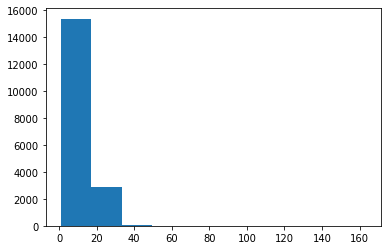

In [31]:
sequence_lengths_val = []

for i in range(len(X_val)):
  sequence_lengths_val.append(len(X_val[i]))

import matplotlib.pyplot as plt

plt.hist(sequence_lengths_val)

(array([3.1518e+04, 9.7210e+03, 1.5150e+03, 2.4000e+01, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 4.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1. ,  13.8,  26.6,  39.4,  52.2,  65. ,  77.8,  90.6, 103.4,
        116.2, 129. ]),
 <a list of 10 Patch objects>)

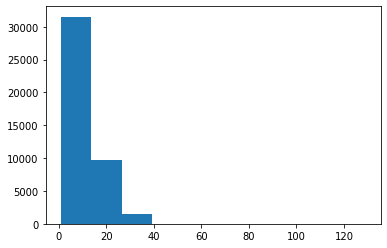

In [32]:
sequence_lengths_train = []

for i in range(len(X_train)):
  sequence_lengths_train.append(len(X_train[i]))

import matplotlib.pyplot as plt

plt.hist(sequence_lengths_train)

In [33]:
pd.Series(sequence_lengths_train).describe()

count    42784.000000
mean         9.937430
std          7.497054
min          1.000000
25%          4.000000
50%          8.000000
75%         14.000000
max        129.000000
dtype: float64

In [34]:
# maior sentenca
max_lenght = max([pd.Series(sequence_lengths_train).max() + 1,pd.Series(sequence_lengths_val).max() + 1])
max_lenght

164

In [35]:
ok

NameError: ignored

In [ ]:
from copy import deepcopy

def pad_X(X, desired_sequence_length=max_lenght):
  X_copy = deepcopy(X)

  for i, x in enumerate(X):
    x_seq_len = x.shape[0]
    sequence_length_difference = desired_sequence_length - x_seq_len
    
    pad = np.zeros(shape=(sequence_length_difference, 50))

    X_copy[i] = np.concatenate([x, pad])
  
  return np.array(X_copy).astype(float)

In [ ]:
X_train = pad_X(X_train)

In [ ]:
print(len(X_train), len(X_train[0]), X_train.shape)
print(len(X_train), len(X_train[65]), X_train.shape)

In [ ]:
y_train.shape

In [ ]:
X_val, y_val = df_to_X_y(df_val)
X_val = pad_X(X_val)

print(X_val.shape, y_val.shape)

### Model


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential([])
model.add(layers.Input(shape=(max_lenght, 50)))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
!ls /content/drive/MyDrive/'Trabalho de Graduação'/scripts/model

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import BinaryCrossentropy


cp = ModelCheckpoint('/content/drive/MyDrive/''Trabalho de Graduação''/scripts/model/', save_best_only=True)
# loss='sparse_categorical_crossentropy'
model.compile(loss=BinaryCrossentropy,optimizer=Adam(learning_rate=0.0001),metrics=['accuracy', AUC(name='auc')])


In [ ]:
model.summary()

In [ ]:
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, callbacks=[cp])

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Bidirectional,Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

In [ ]:
model_glove = Sequential()
model_glove.add(Embedding(len(words), output_dim=100, input_length=max_lenght, trainable=False))
#model_glove.add(Dropout(0.2))
#model_glove.add(Conv1D(64, 2, activation='relu')) 
model_glove.add(LSTM(64))
model_glove.add(Dense(3, activation='softmax'))

model_glove.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
history = model_glove.fit(X_train, y_train, validation_data=(X_val,y_val), epochs = 2,verbose =1)
